In [1]:
import os
import random
import pandas as pd
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage import gaussian_filter1d
from scipy.stats import pointbiserialr
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
)

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)
from side_info_decoding.reduced_rank import (
    Reduced_Rank_Model, 
    train_single_task, 
    model_eval,
    Multi_Task_Reduced_Rank_Model,
    train_multi_task,
)

import pymc3 as pm
from hmmlearn import vhmm
from side_info_decoding.bmm_hmm import (
    BetaProcess, Constrained_BMM_HMM, posterior_inference
)
from side_info_decoding.viz import plot_multi_session_hmm_results, plot_bmm_hmm_results

seed = 666
set_seed(seed)

In [9]:
class ReducedRankRegression(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(ReducedRankRegression, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1,))
        self.double()
        
    def forward(self, x):
        self.beta = self.U @ self.V
        out = torch.einsum("ct,kct->kt", self.beta, x)
        out += self.b
        return out
    
def train_rrr(
    X, 
    Y, 
    train,
    test,
    n_r = 10,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    rrr = ReducedRankRegression(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(rrr.parameters(), lr=learning_rate, weight_decay=1e-3)
    criterion = torch.nn.MSELoss()
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train RRR:"):
        optimizer.zero_grad()
        y_pred = rrr(train_x)
        loss = criterion(y_pred, train_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return rrr, losses

In [10]:
def time_bin_wise_metrics(y_true, y_pred):
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    adj_r2 = explained_variance_score(y_true, y_pred)
    return r2, adj_r2

def sliding_window_over_time(data, window_size=10):
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - window_size + 1, window_size
        ))
        for t in range(window_size-1, n_t_bins):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t - d]
            data_window[:,:,t-window_size] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        data_window = np.zeros((n_trials, n_t_bins - window_size + 1))
        for t in range(window_size-1, n_t_bins):
            data_window[:,t-window_size] = data[:,t]
    return data_window

def causal_decoder(train_X, train_Y, test_X, test_Y, verbose=True):
    penalty = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
    
    train_K, C, T, L = train_X.shape
    test_K, _, _, _ = test_X.shape
    
    train_X = train_X.transpose(0,1,-1,2).reshape(train_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    test_X = test_X.transpose(0,1,-1,2).reshape(test_K, C*L, T).transpose(0,-1,1).reshape((-1, C*L))
    train_Y = train_Y.reshape((-1))
    test_Y = test_Y.reshape((-1))
    
    decoder = GridSearchCV(Ridge(), {"alpha": penalty})
    decoder.fit(train_X, train_Y)
    pred_Y = decoder.predict(test_X)
    test_Y = test_Y.reshape(test_K, T)
    pred_Y = pred_Y.reshape(test_K, T)
    
    r2, adj_r2 = time_bin_wise_metrics(test_Y, pred_Y)
    if verbose:
        print(f"r2: {r2:.3f} adj-r2: {adj_r2:.3f}")
    
    return pred_Y, [r2, adj_r2]

In [99]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 8
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.5)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

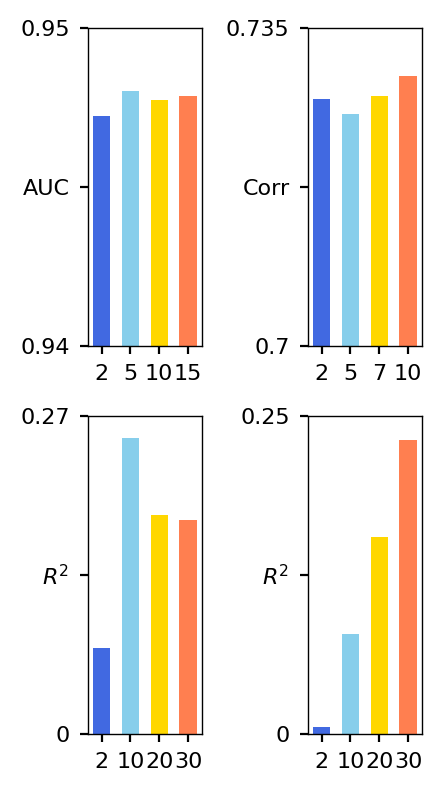

In [117]:
colors = ['royalblue', 'skyblue', 'gold', 'coral']

fig, axes = plt.subplots(2,2, figsize=(2.25, 4))

dir_path = Path("./sensitivity_rank/")
behavior = "choice"
rank = [2, 5, 10, 15]
df = []
for r in rank:
    path = dir_path / behavior / f"rank_{r}"
    metrics = []
    for fold in range(5):
        metrics.append(np.load(path/f"fold_{fold}.npy", allow_pickle=True))
    metrics = np.mean(metrics, 0).mean(0)[1]
    df.append(metrics)

axes[0,0].bar(np.array([0,1,2,3]), np.array(df), color=colors, width=0.6)
axes[0,0].set_ylim(0.94,0.95)
axes[0,0].set_xticks([0,1,2,3], rank)
axes[0,0].set_yticks([0.94, 0.945, 0.95], [0.94, "AUC", 0.95])

behavior = "prior"
rank = [2, 5, 7, 10]
df = []
for r in rank:
    path = dir_path / behavior / f"rank_{r}"
    metrics = []
    for fold in range(5):
        metrics.append(np.load(path/f"fold_{fold}.npy", allow_pickle=True))
    metrics =  np.mean(metrics, 0).mean(0)[1]
    df.append(metrics)
axes[0,1].bar(np.array([0,1,2,3]), np.array(df), color=colors, width=0.6)
axes[0,1].set_ylim(0.7,0.735)
axes[0,1].set_xticks([0,1,2,3], rank)
axes[0,1].set_yticks([0.7, 0.7175, 0.735], [0.7, "Corr", 0.735])

behavior = "wheel_speed"
rank = [2, 10, 20, 30]
df = []
for r in rank:
    path = dir_path / behavior / f"rank_{r}"
    metrics = []
    for pid in [f.split(".")[0] for f in os.listdir(path)]:
        metrics.append(np.load(path/f"{pid}.npy", allow_pickle=True))
    metrics =  np.vstack(metrics).mean(0)[0]
    df.append(metrics)
axes[1,0].bar(np.array([0,1,2,3]), np.array(df), color=colors, width=0.6)
axes[1,0].set_xticks([0,1,2,3], rank)
axes[1,0].set_yticks([0, 0.075, 0.15], [0, r"$R^2$", 0.27])

behavior = "pupil_diameter"
rank = [2, 10, 20, 30]
df = []
for r in rank:
    path = dir_path / behavior / f"rank_{r}"
    metrics = []
    for pid in [f.split(".")[0] for f in os.listdir(path)]:
        metrics.append(np.load(path/f"{pid}.npy", allow_pickle=True))
    metrics =  np.vstack(metrics).mean(0)[0]
    df.append(metrics)
axes[1,1].bar(np.array([0,1,2,3]), np.array(df), color=colors, width=0.6)
axes[1,1].set_xticks([0,1,2,3], rank)
axes[1,1].set_yticks([0, 0.0225, 0.045], [0, r"$R^2$", 0.25])
    
plt.tight_layout()

#### RRR vs. multi-session RRR

In [4]:
# pids = [
#     "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
#     "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
#     "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
#     "523f8301-4f56-4faf-ab33-a9ff11331118",
#     "143dd7cf-6a47-47a1-906d-927ad7fe9117",
#     '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
#     '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
#     '1e176f17-d00f-49bb-87ff-26d237b525f1',
#     '16799c7a-e395-435d-a4c4-a678007e1550',
#      'ad714133-1e03-4d3a-8427-33fc483daf1a',
#      '31f3e083-a324-4b88-b0a4-7788ec37b191',
# ]

pids = [
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "1a60a6e1-da99-4d4e-a734-39b1d4544fad",
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
]

In [5]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="all",
    behavior="prior",
    data_type="all_ks",
    n_t_bins=30,
    prior_path = "/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/priors/"
)

pulling data from ibl database ..
eid: dac3a4c1-b666-4de0-87e8-8c514483cacf
pid: 6fc4d73c-2071-43ec-a756-c6c6d8322c8b
number of trials found: 428
found 428 trials from 281.82 to 3112.92 sec.


Compute spike count: 100%|███████████████████| 428/428 [00:02<00:00, 197.43it/s]


pulling data from ibl database ..
eid: 51e53aff-1d5d-4182-a684-aba783d50ae5
pid: 1a60a6e1-da99-4d4e-a734-39b1d4544fad
number of trials found: 450
found 450 trials from 20.56 to 2612.19 sec.


Compute spike count: 100%|████████████████████| 450/450 [00:06<00:00, 65.50it/s]


pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367
found 367 trials from 17.56 to 2310.24 sec.


Compute spike count: 100%|████████████████████| 367/367 [00:04<00:00, 83.56it/s]


pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 350
found 350 trials from 22.21 to 2393.54 sec.


Compute spike count: 100%|███████████████████| 350/350 [00:02<00:00, 145.79it/s]


pulling data from ibl database ..
eid: c7248e09-8c0d-40f2-9eb4-700a8973d8c8
pid: 84bb830f-b9ff-4e6b-9296-f458fb41d160
number of trials found: 688
found 688 trials from 17.65 to 3851.03 sec.


Compute spike count: 100%|████████████████████| 688/688 [00:31<00:00, 21.53it/s]


pulling data from ibl database ..
eid: 88224abb-5746-431f-9c17-17d7ef806e6a
pid: 523f8301-4f56-4faf-ab33-a9ff11331118
number of trials found: 397
found 397 trials from 37.78 to 2183.45 sec.


Compute spike count: 100%|████████████████████| 397/397 [00:05<00:00, 78.54it/s]


pulling data from ibl database ..
eid: 3638d102-e8b6-4230-8742-e548cd87a949
pid: 143dd7cf-6a47-47a1-906d-927ad7fe9117
number of trials found: 605
found 605 trials from 32.91 to 4786.28 sec.


Compute spike count: 100%|███████████████████| 605/605 [00:03<00:00, 155.62it/s]


In [ ]:
rank = [2, 5, 10, 15]

In [ ]:
d = 3 # half window size
n_epochs = 5000

pids = [
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "1a60a6e1-da99-4d4e-a734-39b1d4544fad",
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
]

X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="all",
    behavior="prior",
    data_type="good_ks",
    n_t_bins=30,
    prior_path = "/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/priors/"
)

skf = KFold(n_splits=5, shuffle=True, random_state=seed)

n_units = []
train_X_dict, test_X_dict, train_Y_dict, test_Y_dict = {}, {}, {}, {}
for pid in pids:
    X, Y = X_dict[pid], Y_dict[pid]
    K, C, T = X.shape
    n_units.append(C)
    X = sliding_window_over_trials(X, half_window_size=d)
    Y = sliding_window_over_trials(Y, half_window_size=d)
    X, Y = torch.tensor(X), torch.tensor(Y)
    train_X_dict.update({pid: [X[train] for train, _ in skf.split(X, Y)]})
    test_X_dict.update({pid: [X[test] for _, test in skf.split(X, Y)]})
    train_Y_dict.update({pid: [Y[train] for train, _ in skf.split(X, Y)]})
    test_Y_dict.update({pid: [Y[test] for _, test in skf.split(X, Y)]})

for R in [2,5,7,10]:
    for fold_idx in range(5):

        print(f"start training fold {fold_idx+1} on {len(pids)} sessions ..")
        train_X_lst = [train_X_dict[pid][fold_idx] for pid in pids]
        test_X_lst = [test_X_dict[pid][fold_idx] for pid in pids]
        train_Y_lst = [train_Y_dict[pid][fold_idx] for pid in pids]
        test_Y_lst = [test_Y_dict[pid][fold_idx] for pid in pids]

        multi_task_rrm = Multi_Task_Reduced_Rank_Model(
            n_tasks=len(pids),
            n_units=n_units, 
            n_t_bins=T, 
            rank=R, 
            half_window_size=d
        )

        # training
        multi_task_rrm, train_losses = train_multi_task(
            model=multi_task_rrm,
            train_dataset=(train_X_lst, train_Y_lst),
            test_dataset=(test_X_lst, test_Y_lst),
            # loss_function=torch.nn.BCELoss(),
            loss_function=torch.nn.MSELoss(),
            learning_rate=1e-3,
            weight_decay=1e-1,
            n_epochs=n_epochs,
        )

        # eval
        test_U, test_V, test_metrics, _ = model_eval(
            multi_task_rrm, 
            train_dataset=(train_X_lst, train_Y_lst),
            test_dataset=(test_X_lst, test_Y_lst),
            behavior="prior"
        )

        save_path = Path("./sensitivity_rank") / "prior" / f"rank_{R}"
        os.makedirs(save_path, exist_ok=True) 
        np.save(save_path/f"fold_{fold_idx}.npy", test_metrics)

In [25]:
rank = [2, 5, 10, 15]

In [26]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

In [31]:
behavior_type = "wheel_speed"

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
]

try:
    X_dict, Y_dict = load_data_from_pids(
        pids,
        brain_region="all",
        behavior=behavior_type,
        data_type="good_ks",
        n_t_bins = 60,
        # align_time_type="feedback_times",
        align_time_type="firstMovement_times",
        t_before=0.2,
        t_after=1.0,
        normalize_input=False
    )
except:
    print(f"PID {pid} data missing.")
            
for R in [2, 10, 20, 30]:
    for pid in pids:

        X, Y = X_dict[pid], Y_dict[pid]
        offset = Y.max()
        Y /= offset
        K, C, T = X.shape
        print(f"PID: {pid} # trials: {K} # neurons {C} # time bins {T}.")

        baseline_metrics = []
        kf = KFold(n_splits=5, shuffle=True, random_state=666)
        for fold_idx, (train, test) in enumerate(kf.split(X, Y)):
            pass

        # baseline
        window_X = sliding_window_over_time(X, window_size=10)
        window_Y = sliding_window_over_time(Y, window_size=10)
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]

        rrr, losses = train_rrr(
            X = X,
            Y = Y, 
            train = train,
            test = test,
            n_r = R,
            learning_rate = 1e-3,
            n_epochs = 5000
        )

        supervised_subspace = rrr.U.detach().numpy()
        subspace_weights = rrr.V.detach().numpy()

        all_proj = X.transpose(0,-1,1) @ supervised_subspace
        weighted_proj = all_proj * subspace_weights.T
        weighted_proj = weighted_proj.transpose(0, -1, 1)

        window_X = sliding_window_over_time(weighted_proj, window_size=10)
        window_Y = sliding_window_over_time(Y, window_size=10)
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]
        rrr_pred, rrr_metric = causal_decoder(train_X, train_Y, test_X, test_Y)

        save_path = Path("./sensitivity_rank") / "wheel_speed" / f"rank_{R}"
        os.makedirs(save_path, exist_ok=True) 
        np.save(save_path/f"{pid}.npy", rrr_metric)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367
found 367 trials from 17.75 to 2310.37 sec.
found 83 good Kilosort units


Compute spike count: 100%|███████████████████| 367/367 [00:00<00:00, 701.66it/s]


pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 350
found 350 trials from 34.74 to 2414.77 sec.
found 85 good Kilosort units


Compute spike count: 100%|██████████████████| 350/350 [00:00<00:00, 1175.86it/s]


pulling data from ibl database ..
eid: 88224abb-5746-431f-9c17-17d7ef806e6a
pid: 523f8301-4f56-4faf-ab33-a9ff11331118
number of trials found: 397
found 397 trials from 38.00 to 2184.27 sec.
found 96 good Kilosort units


Compute spike count: 100%|███████████████████| 397/397 [00:00<00:00, 415.27it/s]


pulling data from ibl database ..
eid: a4a74102-2af5-45dc-9e41-ef7f5aed88be
pid: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a
number of trials found: 369
found 369 trials from 69.83 to 1863.58 sec.
found 131 good Kilosort units


Compute spike count: 100%|███████████████████| 369/369 [00:01<00:00, 332.40it/s]


PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 83 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:48<00:00, 46.19it/s]


r2: 0.044 adj-r2: -0.283
PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 85 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [00:57<00:00, 86.67it/s]


r2: 0.047 adj-r2: -1.047
PID: 523f8301-4f56-4faf-ab33-a9ff11331118 # trials: 397 # neurons 96 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:28<00:00, 56.69it/s]


r2: 0.081 adj-r2: -0.101
PID: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a # trials: 369 # neurons 131 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [21:44<00:00,  3.83it/s]


r2: -0.010 adj-r2: -0.018
PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 83 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:35<00:00, 52.19it/s]


r2: 0.095 adj-r2: -0.232
PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 85 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:24<00:00, 58.83it/s]


r2: 0.123 adj-r2: -0.670
PID: 523f8301-4f56-4faf-ab33-a9ff11331118 # trials: 397 # neurons 96 # time bins 60.


Train RRR:: 100%|██████████████████████████| 5000/5000 [00:48<00:00, 102.11it/s]


r2: 0.236 adj-r2: -0.227
PID: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a # trials: 369 # neurons 131 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [00:59<00:00, 83.83it/s]


r2: 0.105 adj-r2: -0.646
PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 83 # time bins 60.


Train RRR:: 100%|██████████████████████████| 5000/5000 [00:41<00:00, 119.72it/s]


r2: 0.070 adj-r2: -0.596
PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 85 # time bins 60.


Train RRR:: 100%|██████████████████████████| 5000/5000 [00:39<00:00, 126.00it/s]


r2: 0.082 adj-r2: -1.076
PID: 523f8301-4f56-4faf-ab33-a9ff11331118 # trials: 397 # neurons 96 # time bins 60.


Train RRR:: 100%|██████████████████████████| 5000/5000 [00:49<00:00, 101.64it/s]


r2: 0.195 adj-r2: -0.228
PID: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a # trials: 369 # neurons 131 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:21<00:00, 61.68it/s]


r2: 0.065 adj-r2: -0.718
PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 83 # time bins 60.


Train RRR:: 100%|██████████████████████████| 5000/5000 [00:40<00:00, 122.56it/s]


r2: 0.040 adj-r2: -0.714
PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 85 # time bins 60.


Train RRR:: 100%|██████████████████████████| 5000/5000 [00:39<00:00, 126.02it/s]


r2: 0.123 adj-r2: -0.937
PID: 523f8301-4f56-4faf-ab33-a9ff11331118 # trials: 397 # neurons 96 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:23<00:00, 59.69it/s]


r2: 0.211 adj-r2: -0.326
PID: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a # trials: 369 # neurons 131 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [00:57<00:00, 87.15it/s]


r2: 0.028 adj-r2: -1.068


In [35]:
behavior_type = "pupil_diameter"

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    # "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
]

try:
    X_dict, Y_dict = load_data_from_pids(
        pids,
        brain_region="all",
        behavior=behavior_type,
        data_type="good_ks",
        n_t_bins = 60,
        align_time_type="feedback_times",
        # align_time_type="firstMovement_times",
        t_before=0.2,
        t_after=1.0,
        normalize_input=False
    )
except:
    print(f"PID {pid} data missing.")
            
for R in [2, 10, 20, 30]:
    for pid in pids:

        X, Y = X_dict[pid], Y_dict[pid]
        offset = Y.max()
        Y /= offset
        K, C, T = X.shape
        print(f"PID: {pid} # trials: {K} # neurons {C} # time bins {T}.")

        baseline_metrics = []
        kf = KFold(n_splits=5, shuffle=True, random_state=666)
        for fold_idx, (train, test) in enumerate(kf.split(X, Y)):
            pass

        # baseline
        window_X = sliding_window_over_time(X, window_size=10)
        window_Y = sliding_window_over_time(Y, window_size=10)
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]

        rrr, losses = train_rrr(
            X = X,
            Y = Y, 
            train = train,
            test = test,
            n_r = R,
            learning_rate = 1e-3,
            n_epochs = 5000
        )

        supervised_subspace = rrr.U.detach().numpy()
        subspace_weights = rrr.V.detach().numpy()

        all_proj = X.transpose(0,-1,1) @ supervised_subspace
        weighted_proj = all_proj * subspace_weights.T
        weighted_proj = weighted_proj.transpose(0, -1, 1)

        window_X = sliding_window_over_time(weighted_proj, window_size=10)
        window_Y = sliding_window_over_time(Y, window_size=10)
        train_X, test_X = window_X[train], window_X[test]
        train_Y, test_Y = window_Y[train], window_Y[test]
        rrr_pred, rrr_metric = causal_decoder(train_X, train_Y, test_X, test_Y)

        save_path = Path("./sensitivity_rank") / "pupil_diameter" / f"rank_{R}"
        os.makedirs(save_path, exist_ok=True) 
        np.save(save_path/f"{pid}.npy", rrr_metric)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367
found 367 trials from 17.86 to 2310.69 sec.
found 83 good Kilosort units


Compute spike count: 100%|███████████████████| 367/367 [00:00<00:00, 592.97it/s]


pulling data from ibl database ..
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
number of trials found: 350
found 350 trials from 35.51 to 2420.28 sec.
found 85 good Kilosort units


Compute spike count: 100%|██████████████████| 350/350 [00:00<00:00, 1249.99it/s]


pulling data from ibl database ..
eid: 88224abb-5746-431f-9c17-17d7ef806e6a
pid: 523f8301-4f56-4faf-ab33-a9ff11331118
number of trials found: 397
found 397 trials from 38.44 to 4645.14 sec.
found 96 good Kilosort units


Compute spike count: 100%|███████████████████| 397/397 [00:01<00:00, 347.37it/s]


pulling data from ibl database ..
eid: a4a74102-2af5-45dc-9e41-ef7f5aed88be
pid: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a
number of trials found: 369
found 369 trials from 69.96 to 3218.96 sec.
found 131 good Kilosort units


Compute spike count: 100%|███████████████████| 369/369 [00:01<00:00, 305.26it/s]


PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 83 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:17<00:00, 64.19it/s]


r2: 0.066 adj-r2: -0.035
PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 85 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:38<00:00, 50.78it/s]


r2: -0.003 adj-r2: -0.002
PID: 523f8301-4f56-4faf-ab33-a9ff11331118 # trials: 397 # neurons 96 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:51<00:00, 44.89it/s]


r2: -0.001 adj-r2: -0.004
PID: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a # trials: 369 # neurons 131 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [08:31<00:00,  9.77it/s]


r2: -0.059 adj-r2: -0.046
PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 83 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [02:03<00:00, 40.34it/s]


r2: 0.105 adj-r2: -0.110
PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 85 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:59<00:00, 41.78it/s]


r2: 0.011 adj-r2: -0.043
PID: 523f8301-4f56-4faf-ab33-a9ff11331118 # trials: 397 # neurons 96 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [02:15<00:00, 36.96it/s]


r2: 0.020 adj-r2: -0.094
PID: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a # trials: 369 # neurons 131 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [09:42<00:00,  8.58it/s]


r2: -0.080 adj-r2: -0.125
PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 83 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [02:12<00:00, 37.80it/s]


r2: 0.163 adj-r2: -0.097
PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 85 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:36<00:00, 51.88it/s]


r2: 0.062 adj-r2: 0.026
PID: 523f8301-4f56-4faf-ab33-a9ff11331118 # trials: 397 # neurons 96 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [02:29<00:00, 33.41it/s]


r2: -0.007 adj-r2: -0.191
PID: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a # trials: 369 # neurons 131 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [02:51<00:00, 29.16it/s]


r2: -0.106 adj-r2: -0.139
PID: dab512bd-a02d-4c1f-8dbc-9155a163efc0 # trials: 367 # neurons 83 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [01:50<00:00, 45.13it/s]


r2: 0.217 adj-r2: -0.027
PID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 # trials: 350 # neurons 85 # time bins 60.


Train RRR:: 100%|██████████████████████████| 5000/5000 [00:40<00:00, 123.05it/s]


r2: -0.014 adj-r2: -0.076
PID: 523f8301-4f56-4faf-ab33-a9ff11331118 # trials: 397 # neurons 96 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [00:52<00:00, 95.80it/s]


r2: 0.066 adj-r2: -0.115
PID: 0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a # trials: 369 # neurons 131 # time bins 60.


Train RRR:: 100%|███████████████████████████| 5000/5000 [03:48<00:00, 21.87it/s]


r2: -0.102 adj-r2: -0.155
